In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import sklearn.model_selection
import models
import util
import os
import config
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns

# Look at stylegan-generated images

In [2]:
DIR_ORIG = '../data/annotation-dataset-stylegan2/images'
DIRS_STYLEGAN = '../data_processed/stylegan2'

In [3]:
regs = [0, 0.1, 1, 10000]
IM_NUMS = [0, 1, 10]

In [ ]:
plt.figure(dpi=300)
R, C = len(IM_NUMS), 1 + len(regs)
for r, IM_NUM in enumerate(IM_NUMS):
    ims = []
    latents = []
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM}.jpg'))
    for reg in regs:
        folder = f'generated_images_{reg}'
        im_fname = oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.png')
        ims.append(mpimg.imread(im_fname))
        latents.append(np.load(oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.npy')))
        print(np.mean(np.abs(np.corrcoef(latents[-1]))))

    
    plt.subplot(R, C, C * r + 1)
    util.imshow(im_orig)

    for i in range(len(regs)):
        plt.subplot(R, C, C * r + 2 + i)
        util.imshow(ims[i])

# Look at CELEB-A

In [5]:
DIR_ORIG_CELEBA = '../data/CelebA/Img/img_align_celeba'
DIR_SQUARE_CELEBA = '../data/CelebA/Img/img_square_celeba'

**need to first preprocess celeba to be square before running the pipeline**

In [ ]:
for fname in tqdm(sorted(os.listdir(DIR_ORIG_CELEBA))):
    if '.jpg' in fname:
        im = mpimg.imread(oj(DIR_ORIG_CELEBA, fname))
        if not im.shape[0] == im.shape[1]:
            im = im[20:-20]
        plt.imsave(oj(DIR_SQUARE_CELEBA, fname), im)

# look at celeba-hq

In [46]:
DIR_ORIG = '../data/celeba-hq/ims/'
DIRS_GEN = '../data_processed/celeba-hq/'
regs = [0, 0.1, 1, 10000]
IM_NUMS = np.arange(6, 10)

In [ ]:
R, C = len(IM_NUMS), 1 + len(regs)
plt.figure(dpi=120, figsize=(C*2.5, R*2.5))
for r, IM_NUM in enumerate(IM_NUMS):
    ims = []
    latents = []
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM:05}.jpg'))
    for reg in regs:
        folder = f'generated_images_{reg}'
        im_fname = oj(DIRS_GEN, folder, f'{IM_NUM:05}.png')
        ims.append(mpimg.imread(im_fname))
        latents.append(np.load(oj(DIRS_GEN, folder, f'{IM_NUM:05}.npy')))
        # print(np.mean(np.abs(np.corrcoef(latents[-1]))))

    
    plt.subplot(R, C, C * r + 1)
    util.imshow(im_orig)
    if r == 0:
        plt.title('orig', fontsize=9)

    for i in range(len(regs)):
        plt.subplot(R, C, C * r + 2 + i)
        util.imshow(ims[i])
        if r == 0:
            plt.title(f'reg={regs[i]:.2e}', fontsize=9)
    latents = np.array(latents)
plt.tight_layout()

## quantitative eval

In [ ]:
# !python 09_process_latents.py

In [24]:
df = pd.read_pickle('processed/09_df_50.pkl')

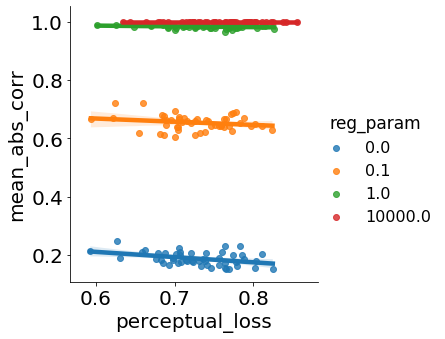

In [31]:
# plt.plot(df['perceptual_loss'], df['mean_abs_corr'], '.')
# d = df[df['im_num'] == 2]
d = df
sns.lmplot('perceptual_loss', 'mean_abs_corr', d, hue='reg_param')
plt.show()

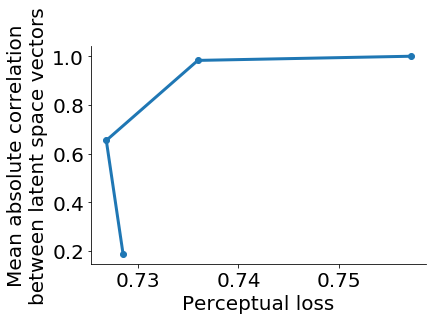

In [45]:
means = df.groupby('reg_param').mean().reset_index()
plt.plot(means['perceptual_loss'], means['mean_abs_corr'], 'o-')
plt.xlabel('Perceptual loss')
plt.ylabel('Mean absolute correlation\nbetween latent space vectors')
plt.show()

In [26]:
attr_map = {
        'A': 'age',
        'B': 'facial-hair',
        'C': 'skin-color',
        'G': 'gender',
        'H': 'hair-length',
        'M': 'makeup',
    }
ks = sorted(attr_map.keys())

In [ ]:
df

In [ ]:
R, C = 2, 3
for i, k in enumerate(ks):
    predk = f'pred_{k}'
    labk = f'lab_{k}'
    sns.lmplot(predk, labk, df, hue='reg_param')
    plt.show()

In [86]:
reg_params = df.reg_param.unique()
accs = np.zeros((len(reg_params), len(ks)))
corrs = np.zeros((len(reg_params), len(ks)))
for i, k in enumerate(ks):
    predk = f'pred_{k}'
    labk = f'lab_{k}'
    for j, reg_param in enumerate(reg_params):
#     sns.lmplot(predk, labk, df, hue='reg_param')
        d = df[df.reg_param == reg_param]
        accs[j, i] = np.mean((d[predk] > 0) == (d[labk] > 0))
        corrs[j, i] = np.corrcoef(d[predk], d[labk])[0, 1]
#     plt.show()

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
def plot_bars(vals, ylab='Accuracy'):
    fig, ax = plt.subplots(dpi=300)
    ind = np.arange(len(ks)) # the x locations for the groups
    ps = []
    for i in range(len(reg_params)):
        width = 0.2
        val = vals[i, :].flatten()
        ps.append(ax.bar(ind + width * i, val, width))
    plt.xticks(ind + width * 1.5, [attr_map[a] for a in ks], fontsize=10)
    plt.ylabel(ylab)
    ax.legend(ps, [f'{reg:.0e}' for reg in reg_params])
    plt.show()
plot_bars(corrs, 'Correlation')
plot_bars(accs, 'Accuracy')